In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from difflib import SequenceMatcher, ndiff
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer


# Import CSV as Dataframes

In [121]:
attributes = pd.read_csv("Contents/attributes.csv", encoding = 'latin')
descriptions = pd.read_csv("Contents/product_descriptions.csv", encoding = 'latin')

test_df = pd.read_csv("Contents/test.csv", encoding="ISO-8859-1")
train_df = pd.read_csv("Contents/train.csv", encoding="ISO-8859-1")

id               74067
product_uid      74067
product_title    74067
search_term      74067
relevance        74067
dtype: int64
53489
product_title
Pressure-Treated Timber #2 Southern Yellow Pine (Common: 4 in. x 4 in. x 8 ft.; Actual: 3.56 in. x 3.56 in. x 96 in.)    21
Lithonia Lighting All Season 4 ft. 2-Light Grey T8 Strip Fluorescent Shop Light                                          21
dtype: int64
count    74067.000000
mean         2.381634
std          0.533984
min          1.000000
25%          2.000000
50%          2.330000
75%          3.000000
max          3.000000
Name: relevance, dtype: float64


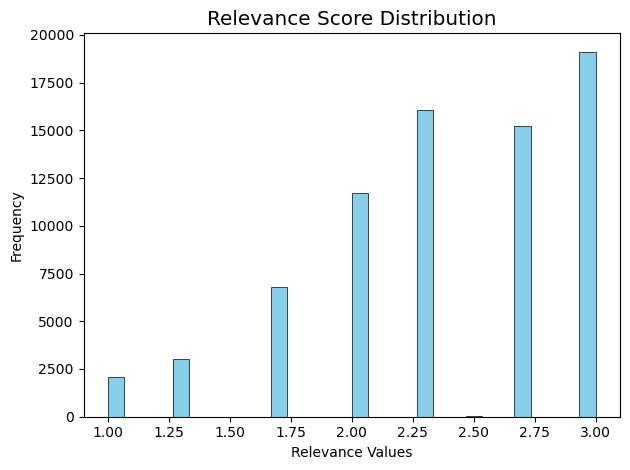

In [125]:
print(train_df.count()) #73392

print(train_df['product_title'].nunique() )# 53489

print(train_df.copy().groupby(['product_title']).size().sort_values(ascending=False)[:2])

print(train_df['relevance'].describe())


fig, ax = plt.subplots(tight_layout=True)
plt.style.use('ggplot')
plt.hist(train_df['relevance'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Relevance Values')
plt.ylabel('Frequency')
plt.title('Relevance Score Distribution')
plt.show()

In [55]:
## See which brands are mostly mentioned in attributes
brand_attribute = attributes.loc[attributes['name']=="MFG Brand Name"]
brand_attribute.groupby("value").count().rename(columns={'name':'frequency'}).sort_values(by="frequency", ascending=False)['frequency']

value
Unbranded                     2954
Hampton Bay                   1723
KOHLER                        1389
Everbilt                      1381
Home Decorators Collection    1275
                              ... 
No Brand                         1
Niza Pro                         1
Niles                            1
Nightlock                        1
Lightning Nugget                 1
Name: frequency, Length: 4287, dtype: int64

In [100]:
def str_stemmer(s):
	return " ".join([stemmer.stem(word) for word in str(s).lower().split()])

attribute_names = attributes.groupby("name").count().sort_values(by="value", ascending=False)

color_attribute = attributes.loc[attributes['name']=='Color Family'].drop(['name'], axis=1).rename(columns={'value':'color_family'})

new_train_df = pd.merge(train_df, color_attribute, how="left", on="product_uid")

new_train_df['color_family'] = new_train_df['color_family'].map(lambda x:str_stemmer(x))

new_train_df

,id,product_uid,product_title,search_term,relevance,color_family
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,nan
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,nan
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,brown / tan
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,chrome
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,chrome
...,...,...,...,...,...,...
74490,221457,206638,Atlantic Windowpane 576 CD or 192 DVD Blu-Ray ...,tv riser glass,1.00,light brown wood
74491,221458,206639,Philips 40-Watt Halogen R20 Flood Light Bulb (...,r20 halogen light,3.00,nan
74492,221463,206641,Schlage Camelot In-Active Aged Bronze Handlese...,schlage lock siena half dummy knob with,2.33,nan
74493,221471,206648,Plastec 11 in. x 24 in. Rose Garden Wall Decor...,zen garden decor,3.00,nan


In [132]:
import spacy
nlp = spacy.load("en_core_web_md")

def similar(a, b):
    if b == 'nan':
        score = np.nan
    else:
        score = SequenceMatcher(None, a, b).ratio()
    return score

def str_common_word(str1, str2):
    if str2 == 'nan':
        common = np.nan
    else:
        common = sum(int(str2.find(word)>=0) for word in str1.split())
    return common

def compute_similarity(input_string, reference_string):
    if reference_string == 'nan':
        score = np.nan
    else:
        diff = ndiff(input_string, reference_string)
        diff_count = 0
        for line in diff:
            if line.startswith("-"):
                diff_count += 1
        score = 1 - (diff_count / len(input_string))
    return score

#new_train_df['color_similarity'] = new_train_df.apply(lambda x: similar(x['search_term'], x['color_family']), axis=1)
#new_train_df['title_similarity'] = new_train_df.apply(lambda x: similar(x['search_term'], x['product_title']), axis=1)

# new_train_df['color_similarity'] = new_train_df.apply(lambda x: str_common_word(x['search_term'], x['color_family']), axis=1)
# new_train_df['title_similarity'] = new_train_df.apply(lambda x: compute_similarity(x['search_term'], x['product_title']), axis=1)

# new_train_df

In [135]:
search_term_nlp = [nlp(x) for x in new_train_df['search_term']]

colors_nlp = [nlp(x) for x in new_train_df['color_family']]

In [136]:
new_train_df['color_similarity'] = new_train_df['similarity_score'] = [search_term_nlp[i].similarity(colors_nlp[i]) for i in range(len(new_train_df))]

# color_similarity = search_term_nlp.similarity(colors_nlp)
print(new_train_df['color_similarity'])

C:\Users\maroo\AppData\Local\Temp\ipykernel_2600\1710678293.py:1: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  new_train_df['color_similarity'] = new_train_df['similarity_score'] = [search_term_nlp[i].similarity(colors_nlp[i]) for i in range(len(new_train_df))]


0       -0.090443
1        0.378849
2        0.015826
3        0.293487
4        0.477647
           ...   
74490    0.399068
74491   -0.125123
74492   -0.084300
74493    0.067950
74494    0.330206
Name: color_similarity, Length: 74495, dtype: float64


In [111]:
stemmer = SnowballStemmer('english')

df_train = pd.read_csv('Contents/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('Contents/test.csv', encoding="ISO-8859-1")
df_attr = pd.read_csv('Contents/attributes.csv')
df_pro_desc = pd.read_csv('Contents/product_descriptions.csv')

# rng=np.random.RandomState(12)
#
# train_indices = rng.choice(74067, replace=False, size=12000)
# df_train = df_train.iloc[train_indices]
#
# test_indices = rng.choice(166693, replace=False, size=9000)
# df_test = df_test.iloc[test_indices]

num_train = df_train.shape[0]

In [112]:
def str_stemmer(s):
	return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
	return sum(int(str2.find(word)>=0) for word in str1.split())

df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')

# df_all['search_term'] = df_all['search_term'].map(lambda x:str_stemmer(x))
# df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))
# df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))

df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)

df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']
df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))

# df_all['title_similarity'] = df_all.apply(lambda x: compute_similarity(x['search_term'], x['product_title']), axis=1)
# df_all['description_similarity'] = df_all.apply(lambda x: compute_similarity(x['search_term'], x['product_description']), axis=1)

df_all = df_all.drop(['search_term','product_title','product_description','product_info'],axis=1)

df_train = df_all.iloc[:num_train]

In [113]:
# df_full_train = pd.read_csv('training_set_stemmed.csv')
# X_train, X_test, y_train, y_test = train_test_split(df_full_train.drop(['id','relevance'],axis=1).values, df_full_train['relevance'].values, test_size=0.20, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['id','relevance'],axis=1).values, df_train['relevance'].values, test_size=0.20, random_state=42)

id_test = X_test[:, 0]
X_train = X_train[:,1:]
X_test = X_test[:,1:]

# df_test = df_all.iloc[num_train:]
# id_test = df_test['id']

# y_train = df_train['relevance'].values
# X_train = df_train.drop(['id','relevance'],axis=1).values
# X_test = df_test.drop(['id','relevance'],axis=1).values

rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('week7_1.csv',index=False)

In [114]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(rmse)

0.5183947609561672
